# LED Isolation Tool — Video simulation or Live RTSP



## imports & functions

In [22]:
# Imports and default parameters
import cv2
import numpy as np
from collections import deque
import time
import sys
import os
import io
# Inline display support for Jupyter/VSCode notebooks
try:
    from IPython.display import display, clear_output, update_display, Image as IPyImage
    from PIL import Image
    _have_ipython = True
except Exception:
    _have_ipython = False

# Display mode: 'auto' detects notebook and uses inline display, 'opencv' forces cv2 windows, 'inline' forces notebook display
# For interactive notebook preview we force inline display by default here.
display_mode = 'inline'

# Track which display IDs we've created to use update_display (reduces flicker)
_display_ids = {}

def in_notebook():
    if display_mode == 'inline':
        return True
    if display_mode == 'opencv':
        return False
    # auto-detect
    return _have_ipython and 'ipykernel' in sys.modules

def show_frame(name, frame, inline_size=(640,360)):
    """Show frame either with cv2.imshow (desktop) or inline display (notebook).

    Uses update_display when available to replace the previous image without clearing the
    whole output area (significantly reduces the black flicker between frames).
    """
    if in_notebook():
        try:
            # convert to PIL and to PNG bytes for IPython Image
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil = Image.fromarray(img)
            # smaller inline size speeds rendering; caller may pass a different size
            pil = pil.resize(inline_size)
            buf = io.BytesIO()
            pil.save(buf, format='PNG')
            buf.seek(0)
            ipy_img = IPyImage(data=buf.getvalue())
            # Use display_id to update in-place (no clear_output)
            if name not in _display_ids:
                try:
                    display(ipy_img, display_id=name)
                    _display_ids[name] = True
                except Exception:
                    # fallback to clear_output path
                    clear_output(wait=True)
                    display(ipy_img)
                    _display_ids[name] = True
            else:
                try:
                    update_display(ipy_img, display_id=name)
                except Exception:
                    # fallback: re-display with clear_output
                    clear_output(wait=True)
                    display(ipy_img)
        except Exception as e:
            # fallback to cv2 window if inline fails
            print('⚠️ Inline display failed:', e)
            cv2.imshow(name, frame)
    else:
        cv2.imshow(name, frame)

# Processing parameters (HSV-only)
processing_params = {
    'method': 0,            # HSV method
    'hue_min': 31,          
    'hue_max': 66,            
    'sat_min': 10,          
    'val_min': 184,         
}



In [23]:
# Core functions: UI, processing methods and helpers
def create_trackbars():
    """Create trackbars for interactive parameter tuning (HSV-only)."""
    cv2.namedWindow('Controls', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Controls', 400, 220)
    # HSV parameters
    cv2.createTrackbar('Hue Min', 'Controls', processing_params['hue_min'], 179, lambda x: None)
    cv2.createTrackbar('Hue Max', 'Controls', processing_params['hue_max'], 179, lambda x: None)
    cv2.createTrackbar('Sat Min', 'Controls', processing_params['sat_min'], 255, lambda x: None)
    cv2.createTrackbar('Val Min', 'Controls', processing_params['val_min'], 255, lambda x: None)

def update_params():
    """Read values from trackbars and update processing_params (HSV-only)."""
    processing_params['hue_min'] = cv2.getTrackbarPos('Hue Min', 'Controls')
    processing_params['hue_max'] = cv2.getTrackbarPos('Hue Max', 'Controls')
    processing_params['sat_min'] = cv2.getTrackbarPos('Sat Min', 'Controls')
    processing_params['val_min'] = cv2.getTrackbarPos('Val Min', 'Controls')

def enhance_frame(frame):
    """Apply light Gaussian blur to reduce noise."""
    return cv2.GaussianBlur(frame, (3, 3), 0)

def method_hsv_color(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([processing_params['hue_min'], processing_params['sat_min'], processing_params['val_min']])
    upper_yellow = np.array([processing_params['hue_max'], 255, 255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

# Removed temporal and advanced methods; keep only HSV path in process_frame

def process_frame(frame):
    return method_hsv_color(frame)

def display_info(frame, processed):
    # Overlay method name and object count on the frame (only on original)
    method_name = 'HSV Color'
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    object_count = len(contours)
    cv2.putText(frame, f"Method: {method_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(frame, f"Objects: {object_count}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    return frame


## Video Processing with Tuned Parameters


**Your optimized parameters:**
- Hue Min: 31
- Hue Max: 66
- Sat Min: 10
- Val Min: 184

These parameters will be locked into the live processing to ensure consistent yellow LED detection.

In [17]:
# Camera configuration (edit these values)
# input_mode: 'rtsp' (live camera), 'file' (video file), 'webcam' (local webcam)
input_mode = 'file'  # change to 'file' or 'webcam' as needed
video_file_path = r"C:\Users\talha\Videos\לדים - בדיקה\yellow - still - led algorithm check.mp4"  # used when input_mode=='file'    
# RTSP settings (used when input_mode == 'rtsp')
if input_mode == 'rtsp':
    ip = "169.254.196.44"  # camera IP
    port = "8554"
    username = "fgcam"
    password = "admin"
    stream_path = "/0/unicast"
    rtsp_url = f"rtsp://{username}:{password}@{ip}:{port}{stream_path}"

def quick_test_connection(mode):
    """Try opening the selected source and grab one frame. Return (ok, message)."""
    try:
        if mode == 'webcam':
            src = 0
        elif mode == 'file':
            src = video_file_path
        else:
            src = rtsp_url
        cap = cv2.VideoCapture(src)
        cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        ok, frame = cap.read()
        cap.release()
        if ok:
            return True, f"Source reachable ({mode})"
        else:
            return False, f"Could not read frame from source ({mode})"
    except Exception as e:
        return False, str(e)

# Quick test based on selected input_mode
ok, msg = quick_test_connection(input_mode)
if not ok:
    print(f"❌ Source test failed: {msg}")
else:
    print("✅ Source test passed — ready to run main loop")

✅ Source test passed — ready to run main loop


▶️ Processing started with looping (press 'q' to quit)


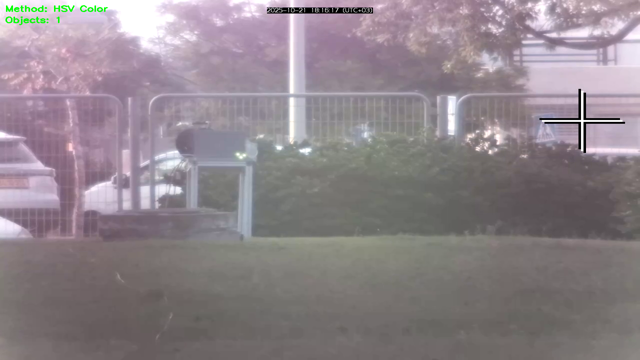

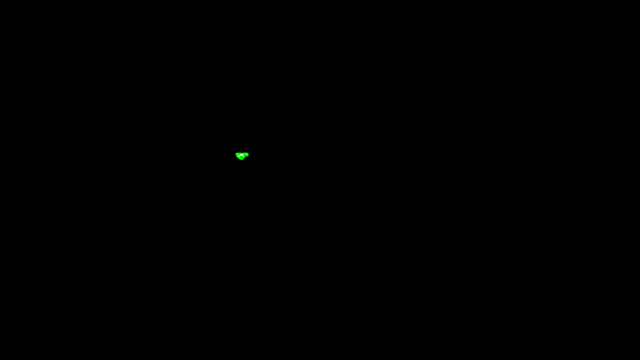

⏱️ FPS: 20.8 | Objects: 0 | Method: HSV | Loop: 0
🔄 Video loop 1 - restarting from beginning
⏱️ FPS: 20.9 | Objects: 0 | Method: HSV | Loop: 1
⏱️ FPS: 20.9 | Objects: 110 | Method: HSV | Loop: 1
🔄 Video loop 2 - restarting from beginning
⏱️ FPS: 20.0 | Objects: 169 | Method: HSV | Loop: 2
🔄 Video loop 3 - restarting from beginning
⏱️ FPS: 19.5 | Objects: 0 | Method: HSV | Loop: 3
⏱️ FPS: 19.6 | Objects: 4 | Method: HSV | Loop: 3
🔄 Video loop 4 - restarting from beginning
⏱️ FPS: 19.2 | Objects: 1 | Method: HSV | Loop: 4
🔄 Video loop 5 - restarting from beginning
⏱️ FPS: 16.2 | Objects: 4 | Method: HSV | Loop: 5
⏱️ FPS: 14.3 | Objects: 4 | Method: HSV | Loop: 5
🔄 Video loop 6 - restarting from beginning
⏱️ FPS: 14.7 | Objects: 0 | Method: HSV | Loop: 6
⏱️ FPS: 15.1 | Objects: 3 | Method: HSV | Loop: 6
🔄 Video loop 7 - restarting from beginning
⏱️ FPS: 15.4 | Objects: 1 | Method: HSV | Loop: 7
🔄 Video loop 8 - restarting from beginning
⏱️ FPS: 15.7 | Objects: 0 | Method: HSV | Loop: 8
⏱️

In [18]:
# Main execution with video looping
def run_main_loop_with_looping(input_mode='file', video_file_path= r"C:\Users\talha\Videos\לדים - בדיקה\yellow - still - led algorithm check.mp4"):
    # Determine source based on input_mode
    if input_mode == 'webcam':
        source = 0
    elif input_mode == 'file':
        if video_file_path is None:
            video_file_path = globals().get('video_file_path')
        source = video_file_path
    else:
        source = rtsp_url
    
    # For looping, we need to track the source path for video files
    original_source = source
    
    cap = cv2.VideoCapture(source)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
    cap.set(cv2.CAP_PROP_FPS, 30)
    if not cap.isOpened():
        print("❌ Unable to open video source. Check camera settings.")
        return
    
    # Create UI
    create_trackbars()
    # Only create and move cv2 windows when using OpenCV display
    use_opencv_windows = not in_notebook()
    if use_opencv_windows:
        cv2.namedWindow('Original', cv2.WINDOW_NORMAL)
        cv2.namedWindow('Processed', cv2.WINDOW_NORMAL)
        try:
            cv2.moveWindow('Original', 100, 100)
            cv2.moveWindow('Processed', 700, 100)
            cv2.moveWindow('Controls', 1300, 100)
        except Exception:
            pass
    
    print("▶️ Processing started with looping (press 'q' to quit)")
    frame_count = 0
    start_time = time.time()
    loop_count = 0
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                # For file input, restart the video when EOF is reached
                if input_mode == 'file':
                    loop_count += 1
                    print(f"🔄 Video loop {loop_count} - restarting from beginning")
                    cap.release()
                    cap = cv2.VideoCapture(original_source)
                    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                    cap.set(cv2.CAP_PROP_FPS, 30)
                    if cap.isOpened():
                        continue  # Try reading the first frame of the restarted video
                    else:
                        print("❌ Failed to restart video")
                        break
                else:
                    # live sources: retry after a short pause
                    time.sleep(0.05)
                    continue
            
            frame_count += 1
            update_params()
            processed = process_frame(frame)
            display_frame = display_info(frame.copy(), processed)
            processed_color = cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR)
            # draw contours on processed_color (without numbering)
            contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                cv2.drawContours(processed_color, [contour], -1, (0, 255, 0), 2)
            # Display frames using chosen mode
            show_frame('Original', display_frame)
            show_frame('Processed', processed_color)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                print('📌 Current parameters:')
                for k, v in processing_params.items():
                    print(f'  {k}: {v}')
            elif key == ord('r'):
                # Manual restart key
                if input_mode == 'file':
                    print("🔄 Manual restart")
                    cap.release()
                    cap = cv2.VideoCapture(original_source)
                    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                    cap.set(cv2.CAP_PROP_FPS, 30)
            # map keys '1','2','3' removed (only one method)
            if frame_count % 150 == 0:
                elapsed = time.time() - start_time
                fps = frame_count / elapsed if elapsed>0 else 0
                # minimal periodic status (every ~5s)
                print(f'⏱️ FPS: {fps:.1f} | Objects: {len(contours)} | Method: HSV | Loop: {loop_count}')
    except KeyboardInterrupt:
        pass
    except Exception as e:
        print(f'❌ Error during processing: {e}')
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print('⏹️ Processing stopped')

# Run main loop with looping when this cell is executed
run_main_loop_with_looping(input_mode=globals().get('input_mode', 'file'), video_file_path=globals().get('video_file_path'))

## Live RTSP Processing with Tuned Parameters

The cells below are configured for live RTSP camera processing using the HSV parameters you've optimized from the video file testing above.

**Your optimized parameters:**
- Hue Min: 31
- Hue Max: 66
- Sat Min: 10
- Val Min: 184

These parameters will be locked into the live processing to ensure consistent yellow LED detection.

In [ ]:
# Optimized HSV Parameters for Live RTSP Processing
# These are the parameters you found that work well for yellow LED detection

optimized_params = {
    'method': 0,            # HSV method
    'hue_min': 31,          # From your testing
    'hue_max': 66,          # From your testing  
    'sat_min': 10,          # From your testing
    'val_min': 184,         # From your testing
}

print("✅ Optimized parameters loaded:")
for k, v in optimized_params.items():
    print(f"  {k}: {v}")
    
# Function to apply optimized parameters to processing_params
def apply_optimized_params():
    global processing_params
    processing_params.update(optimized_params)
    print("🎯 Applied optimized parameters to processing")

# Apply them now
apply_optimized_params()

In [ ]:
# RTSP Camera Configuration for Live Processing
# Configure your RTSP camera settings here

# RTSP camera settings
rtsp_config = {
    'ip': "169.254.196.44",      # Your camera IP address
    'port': "8554",              # Camera RTSP port
    'username': "fgcam",         # Camera username
    'password': "admin",         # Camera password  
    'stream_path': "/0/unicast", # Camera stream path
}

# Build RTSP URL
rtsp_url = f"rtsp://{rtsp_config['username']}:{rtsp_config['password']}@{rtsp_config['ip']}:{rtsp_config['port']}{rtsp_config['stream_path']}"
print(f"🔗 RTSP URL: {rtsp_url}")

def test_rtsp_connection():
    """Test connection to RTSP camera."""
    try:
        cap = cv2.VideoCapture(rtsp_url)
        cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        ret, frame = cap.read()
        cap.release()
        if ret and frame is not None:
            print("✅ RTSP connection successful")
            print(f"📐 Frame size: {frame.shape}")
            return True
        else:
            print("❌ RTSP connection failed - could not read frame")
            return False
    except Exception as e:
        print(f"❌ RTSP connection error: {e}")
        return False

# Test the connection
print("🔍 Testing RTSP connection...")
rtsp_connected = test_rtsp_connection()

In [ ]:
# Live RTSP Processing with Locked Optimized Parameters
def run_rtsp_live_processing(show_controls=False):
    """
    Run live RTSP processing with your optimized HSV parameters.
    
    Args:
        show_controls: Whether to show parameter adjustment controls (default: False for locked params)
    """
    # Use optimized parameters (locked)
    live_params = optimized_params.copy()
    
    # Connect to RTSP stream
    cap = cv2.VideoCapture(rtsp_url)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)  # Minimize latency
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    if not cap.isOpened():
        print("❌ Unable to connect to RTSP camera")
        print(f"📡 URL: {rtsp_url}")
        print("💡 Check camera IP, credentials, and network connection")
        return
    
    # Create UI elements
    if show_controls:
        create_trackbars()
        # Set trackbars to optimized values
        cv2.setTrackbarPos('Hue Min', 'Controls', live_params['hue_min'])
        cv2.setTrackbarPos('Hue Max', 'Controls', live_params['hue_max'])
        cv2.setTrackbarPos('Sat Min', 'Controls', live_params['sat_min'])
        cv2.setTrackbarPos('Val Min', 'Controls', live_params['val_min'])
    
    # Setup display windows
    use_opencv_windows = not in_notebook()
    if use_opencv_windows:
        cv2.namedWindow('RTSP Original', cv2.WINDOW_NORMAL)
        cv2.namedWindow('RTSP Processed', cv2.WINDOW_NORMAL)
        try:
            cv2.moveWindow('RTSP Original', 100, 100)
            cv2.moveWindow('RTSP Processed', 700, 100)
            if show_controls:
                cv2.moveWindow('Controls', 1300, 100)
        except Exception:
            pass
    
    print("▶️ Live RTSP processing started")
    print(f"🎯 Using optimized parameters: Hue({live_params['hue_min']}-{live_params['hue_max']}), Sat({live_params['sat_min']}+), Val({live_params['val_min']}+)")
    print("⚡ Press 'q' to quit, 's' to show parameters, 'p' to print detection results")
    
    frame_count = 0
    start_time = time.time()
    detection_log = []
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("⚠️ Lost connection to RTSP stream, attempting reconnection...")
                cap.release()
                time.sleep(1)
                cap = cv2.VideoCapture(rtsp_url)
                cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                continue
            
            frame_count += 1
            
            # Update parameters if controls are enabled
            if show_controls:
                live_params['hue_min'] = cv2.getTrackbarPos('Hue Min', 'Controls')
                live_params['hue_max'] = cv2.getTrackbarPos('Hue Max', 'Controls')
                live_params['sat_min'] = cv2.getTrackbarPos('Sat Min', 'Controls')
                live_params['val_min'] = cv2.getTrackbarPos('Val Min', 'Controls')
            
            # Process frame with locked parameters
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            lower_yellow = np.array([live_params['hue_min'], live_params['sat_min'], live_params['val_min']])
            upper_yellow = np.array([live_params['hue_max'], 255, 255])
            mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
            
            # Morphological operations
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            
            # Find contours and add info overlay
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            display_frame = frame.copy()
            cv2.putText(display_frame, f"LIVE RTSP - HSV Detection", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(display_frame, f"LEDs Detected: {len(contours)}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(display_frame, f"Frame: {frame_count}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            # Create processed visualization
            processed_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
            for contour in contours:
                cv2.drawContours(processed_color, [contour], -1, (0, 255, 0), 2)
            
            # Log detections periodically
            if len(contours) > 0 and frame_count % 30 == 0:  # Every ~1 second at 30fps
                detection_log.append({
                    'frame': frame_count,
                    'timestamp': time.time(),
                    'led_count': len(contours)
                })
            
            # Display frames
            show_frame('RTSP Original', display_frame, inline_size=(480, 270))
            show_frame('RTSP Processed', processed_color, inline_size=(480, 270))
            
            # Handle keyboard input
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                print('📌 Current live parameters:')
                for k, v in live_params.items():
                    print(f'  {k}: {v}')
            elif key == ord('p'):
                print(f'🔍 Recent detections (last {min(10, len(detection_log))} entries):')
                for entry in detection_log[-10:]:
                    print(f"  Frame {entry['frame']}: {entry['led_count']} LEDs detected")
            
            # Periodic status
            if frame_count % 150 == 0:
                elapsed = time.time() - start_time
                fps = frame_count / elapsed if elapsed > 0 else 0
                recent_detections = len([d for d in detection_log if time.time() - d['timestamp'] < 10])
                print(f'📊 FPS: {fps:.1f} | Total Frames: {frame_count} | Recent LED Detections: {recent_detections}/10s')
                
    except KeyboardInterrupt:
        pass
    except Exception as e:
        print(f'❌ Error during live processing: {e}')
    finally:
        cap.release()
        cv2.destroyAllWindows()
        total_detections = len(detection_log)
        print(f'⏹️ Live processing stopped')
        print(f'📈 Session Summary: {frame_count} frames processed, {total_detections} LED detection events logged')

# Run live RTSP processing (with locked parameters)
print("🚀 Starting live RTSP processing with your optimized parameters...")
print("🔒 Parameters are locked to your tested values for consistent detection")
run_rtsp_live_processing(show_controls=False)

## Advanced Live Processing Options

If you want to fine-tune parameters during live RTSP processing, run the cell below instead. This allows real-time parameter adjustment while maintaining your optimized values as defaults.

In [ ]:
# Live RTSP with Adjustable Parameters (Advanced Mode)
# Run this if you want to adjust parameters during live processing

print("🎛️ Starting live RTSP processing with parameter controls...")
print("🔧 You can adjust HSV parameters in real-time using the Controls window")
print("📍 Starting values are your optimized parameters")
run_rtsp_live_processing(show_controls=True)